# Training a model

This notebook takes input TTrees that contain event-level branches and classifies between different groups of events.

## Preparing the dataframe

In [1]:
import os, sys
import numpy as np
import uproot
import pandas as pd

In [2]:
#Global parameters:
indir = '../input_files/trees/forTraining/'
#chno = 0 #mumu 

In [3]:
#Given a TFile, read its branches into a dataframe.
def read_file_into_df(filepath, truth):

    filename = filepath.split('/')[-1]
    sample = filename.split("_")[1]
    subsample = "_".join(filename.split("_")[2:])
    
    #Exceptions
    if 'QCD' in filename or 'VLL' in filename:
        sample = filename.split("_")[1]+"_"+filename.split("_")[2]
        subsample = filename.split("_")[3].split(".")[0]
        
    if subsample.endswith(".root"): subsample = subsample[:-5]

    tfile = uproot.open(filepath)
    ttree = tfile['myEvents']
    branches = ttree.keys()
    awkarray = ttree.arrays(branches)
    df = pd.DataFrame(awkarray.to_list())
    df['truth'] = truth
    df['sample'] = sample
    df['subsample'] = subsample

    #print(f'dataframe for {sample} {subsample} loaded.')
    return df

def prepare_df(jobname, samples, truth, nmax=None):
    print(f'\nPicking files from {os.path.join(indir, jobname)}')
    dfout = pd.DataFrame()
    for s in samples:
        files = os.listdir(os.path.join(indir, jobname))
        for f in files:
            if s not in f: continue
            filepath = os.path.join(indir, jobname, f)
            df = read_file_into_df(filepath, truth)
            if df.empty:
                print(f"\033[0;31mWarning: Skipping empty file: {f}\033[0m")
                continue
            else:
                #Skim df:
                if nmax is not None and len(df) > nmax:
                    df = df.sample(frac=1).reset_index(drop=True)
                    df = df.head(nmax)
                    
                dfout = pd.concat([dfout, df], ignore_index=True)
                print(f"dataframe for {f} loaded.")

    return dfout

print('Functions loaded.')

Functions loaded.


### Reading the trees into dataframes

In [4]:
%%time

bkgsamples = ['QCD_MuEnriched', 'QCD_EMEnriched']

sigsamples = ['VLLD_mu_M200', 'VLLD_mu_M300', 'VLLD_mu_M400', 'VLLD_mu_M600', 'VLLD_mu_M800']
#sigsamples = ['VLLD_ele_M200', 'VLLD_ele_M300', 'VLLD_ele_M400', 'VLLD_ele_M600', 'VLLD_ele_M800']

bkgdf = prepare_df('tree_2018UL_forTraining_Feb05', bkgsamples, 0)
sigdf = prepare_df('tree_2018UL_forTraining_Feb05', sigsamples, 1)

print('\033[1;32mDone reading samples.\033[0m\n')

modelname = 'qcd-vs-vlld-mu-2018_UL-feb06'
os.makedirs(modelname, exist_ok=True)

print('Ready to proceed.')


Picking files from ../input_files/trees/forTraining/tree_2018UL_forTraining_Feb05
dataframe for tree_QCD_MuEnriched_120to170.root loaded.
dataframe for tree_QCD_MuEnriched_170to300.root loaded.
dataframe for tree_QCD_MuEnriched_20to30.root loaded.
dataframe for tree_QCD_MuEnriched_300to470.root loaded.
dataframe for tree_QCD_MuEnriched_30to50.root loaded.
dataframe for tree_QCD_MuEnriched_470to600.root loaded.
dataframe for tree_QCD_MuEnriched_50to80.root loaded.
dataframe for tree_QCD_MuEnriched_600to800.root loaded.
dataframe for tree_QCD_MuEnriched_800to1000.root loaded.
dataframe for tree_QCD_MuEnriched_80to120.root loaded.
dataframe for tree_QCD_EMEnriched_120to170.root loaded.
dataframe for tree_QCD_EMEnriched_170to300.root loaded.
dataframe for tree_QCD_EMEnriched_20to30.root loaded.
dataframe for tree_QCD_EMEnriched_300toInf.root loaded.
dataframe for tree_QCD_EMEnriched_30to50.root loaded.
dataframe for tree_QCD_EMEnriched_50to80.root loaded.
dataframe for tree_QCD_EMEnriched

In [5]:
nsig_og = sigdf.shape[0]
nbkg_og = bkgdf.shape[0]
print(f'Signal: {nsig_og}')
print(f'Background: {nbkg_og}')

'''
# Maintaining equal proportions of backgrounds:
# Step 1: Get the background sample counts where df['truth'] == 0
bkg_counts = bkgdf['sample'].value_counts()
# Print individual background counts before balancing
print("\nIndividual background counts before balancing:")
for sample, count in bkg_counts.items(): print(f'{sample:<7} : {count}')
    
# Separate small and large background samples
small_samples = bkg_counts[bkg_counts < 100]
large_samples = bkg_counts[bkg_counts >= 100]
# Step 2: Downsample large background samples to the minimum count among them
if large_samples.nunique() != 1:
    min_count = large_samples.min()
    print(f'min = {min_count}')
    # Downsample each large sample to the minimum count
    downsampled_bkg = pd.concat([
        bkgdf[bkgdf['sample'] == sample].sample(n=min_count, random_state=42)
        for sample in large_samples.index
    ])
    small_bkg = bkgdf[bkgdf['sample'].isin(small_samples.index)]
    # Combine the downsampled large background, small background, and signal
    df_balanced = pd.concat([downsampled_bkg, small_bkg])
else:
    df_balanced = bkgdf
    
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_counts = df_balanced['sample'].value_counts()
print("\nIndividual background counts after balancing:")
for sample, count in balanced_counts.items(): print(f'{sample:<7} : {count}')
nbkg = df_balanced.shape[0]
print('-'*15+'\n'+f'{"Total":<7} : {nbkg}')

# Balancing with signal:
bkgdf_reduced = df_balanced.sample(n=6000, random_state=42).reset_index(drop=True)
nbkg = bkgdf.shape[0]
print(f'\nTotal background after dropping random branches: {nbkg}')
'''

#Filtering:
filter = 'lep0_iso < 1.0 and lep1_iso < 1.0'
#filter = filter + ' and 0.50 < nnscore_qcd_vlldmu_200_800 < 0.70 and ST > 150'
sigdf = sigdf.query(filter)
bkgdf = bkgdf.query(filter)
bkgdf_reduced = bkgdf.sample(n=10000, random_state=42).reset_index(drop=True)

#Concatenating and filtering:
df = pd.concat([sigdf, bkgdf_reduced])
#df = pd.concat([sigdf, bkgdf])
#df = df.query('lep0_iso < 1.0 and lep1_iso < 1.0')
nsig = df[df['truth'] == 1].shape[0]
nbkg = df[df['truth'] == 0].shape[0]

print(f'Final signal and background: {nsig}, {nbkg}')

Signal: 9677
Background: 35858
Final signal and background: 9677, 10000


### Filtering the dataframe

In [6]:
df

,channel,trigger,nlep,njet,nbjet,lep0_pt,lep0_eta,lep0_phi,lep0_iso,lep0_sip3d,...,jec,jer,wt_leptonSF,wt_trig,wt_pileup,wt_bjet,weight,truth,sample,subsample
0,1,2,2,2,1,85.616966,-1.095947,-0.970337,0.016173,1.048828,...,1.0,0.997512,0.958128,0.998162,0.990842,0.956004,0.947609,1,VLLD_mu,M200
1,1,0,2,2,0,83.356842,-1.280273,1.336182,0.163900,0.654785,...,1.0,0.983055,1.039471,0.950463,0.912355,0.975023,0.901387,1,VLLD_mu,M200
2,0,0,2,0,0,42.613998,0.658447,2.667969,0.000000,0.315674,...,1.0,1.000000,0.969545,0.977807,0.980164,1.000000,0.929223,1,VLLD_mu,M200
3,0,0,2,0,0,113.763756,-0.953247,-2.133301,0.015902,1.751953,...,1.0,1.000000,0.979143,0.997546,0.990842,1.000000,0.967796,1,VLLD_mu,M200
4,1,2,2,1,0,58.542812,0.878296,2.676758,0.014527,0.322998,...,1.0,1.016883,0.959870,0.998162,0.856406,0.951774,0.820527,1,VLLD_mu,M200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,2,2,0,31.068102,1.798340,-1.220459,0.900501,5.324219,...,1.0,1.004055,0.969680,0.953197,0.946417,1.000000,0.874770,0,QCD_MuEnriched,50to80
9996,0,3,2,1,0,42.878040,1.641846,1.790771,0.492698,6.347656,...,1.0,0.982424,0.978255,0.953162,0.882101,1.000000,0.822503,0,QCD_MuEnriched,120to170
9997,0,0,2,0,0,39.299015,0.528320,1.453613,0.093573,3.824219,...,1.0,1.000000,0.976730,0.950463,1.008838,1.000000,0.936551,0,QCD_MuEnriched,80to120
9998,0,3,2,1,0,73.821762,1.353760,0.160858,0.777259,15.984375,...,1.0,0.994282,0.983586,0.950463,1.047111,1.000000,0.978904,0,QCD_MuEnriched,170to300


### Exploring the variables

In [7]:
import matplotlib.pyplot as plt
import math
os.makedirs(f'{modelname}/before_training', exist_ok=True)

def latexname(var, alias): return alias.get(var, var) #Either get the latexname, or return the default name.

def plot_in_group(listvar, figname, suptitle=None, alias=None):
    num_vars = len(listvar)
    ncols = 4
    nrows = math.ceil(num_vars / ncols)
    vertical_size = nrows * 2.5
    
    fig, ax = plt.subplots(nrows, ncols, figsize=(12, vertical_size))
    ax = ax.flatten()
    
    decorate_hist = {
        'bins':'auto',
        'histtype':'step',
        'linewidth':1.5,
        'density':True,
        'log':False
    }
    
    for i, var in enumerate(listvar):        
        sigdata = df[df['truth'] == 1][var]
        bkgdata = df[df['truth'] == 0][var]
        nsig = len(sigdata)
        nbkg = len(bkgdata)
        ax[i].hist(sigdata, label=f'sig [{nsig}]', color='xkcd:green', **decorate_hist)
        ax[i].hist(bkgdata, label=f'bkg [{nbkg}]', color='xkcd:blue',  **decorate_hist)
        if not alias: ax[i].set_title(var, fontsize=10)
        else: ax[i].set_title(latexname(var, alias), fontsize=10)
        ax[i].legend(loc='best', fontsize=8)
        ax[i].tick_params(axis='both', labelsize=6)
    
    for j in range(i+1, len(ax)): fig.delaxes(ax[j])

    if suptitle: fig.suptitle(suptitle, fontsize=12)
    
    
    plt.tight_layout()
    plt.savefig(f'{modelname}/before_training/{figname}.png', dpi=300)
    plt.show()

print('Ready to plot!')

Ready to plot!


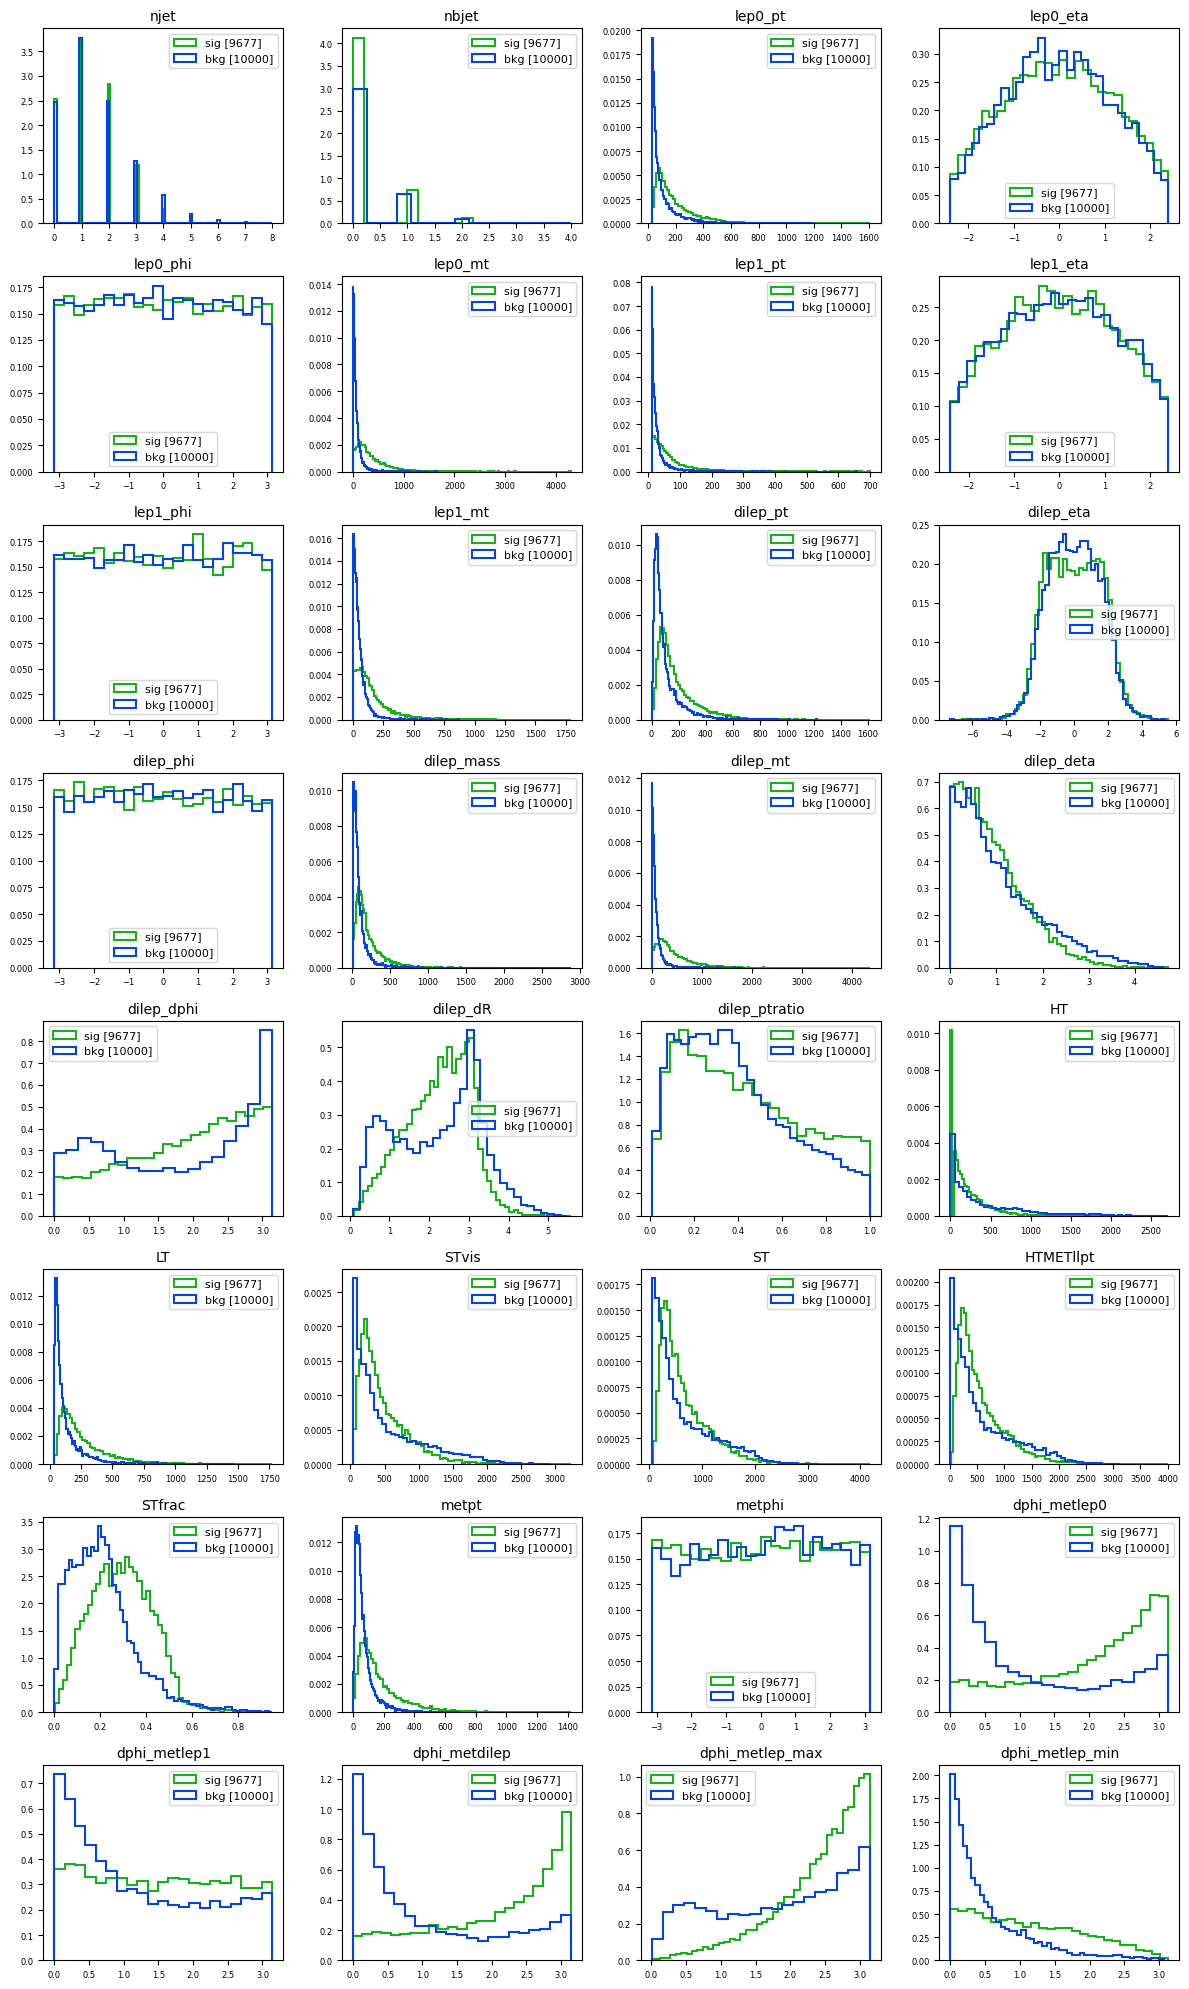

In [8]:
allvar = list(df.keys())

skipvar = ['channel', 'nlep', 'lep0_iso', 'lep0_sip3d', 'lep1_iso', 'lep1_sip3d',
           'jec', 'jer','wt_leptonSF', 'wt_trig', 'wt_bjet', 'wt_pileup', 'weight', 'truth', 'sample', 'subsample',
           'trigger',
           #'flag_qcd', 'flag_searchregion',
          ]
plotvar = [var for var in allvar if var not in skipvar]

plot_in_group(plotvar, 'exploring_all_var')

### Deciding which variables to train on

The following input variables are chosen.
njet                $N_{\text{J}}$
dilep_dR            $\Delta R(L_{0}, L_{1})$
dilep_ptratio       $p_{T1}/p_{T0}$
HT                  $H_{T}$
LT                  $L_{T}$
STfrac              $S_{T}^{\text{  frac}}$
metpt               metpt
dphi_metlep0        $\Delta\phi(L_{0}, p_{T}^{\text{  miss}})$
dphi_metdilep       $\Delta\phi(LL, p_{T}^{\text{  miss}})$


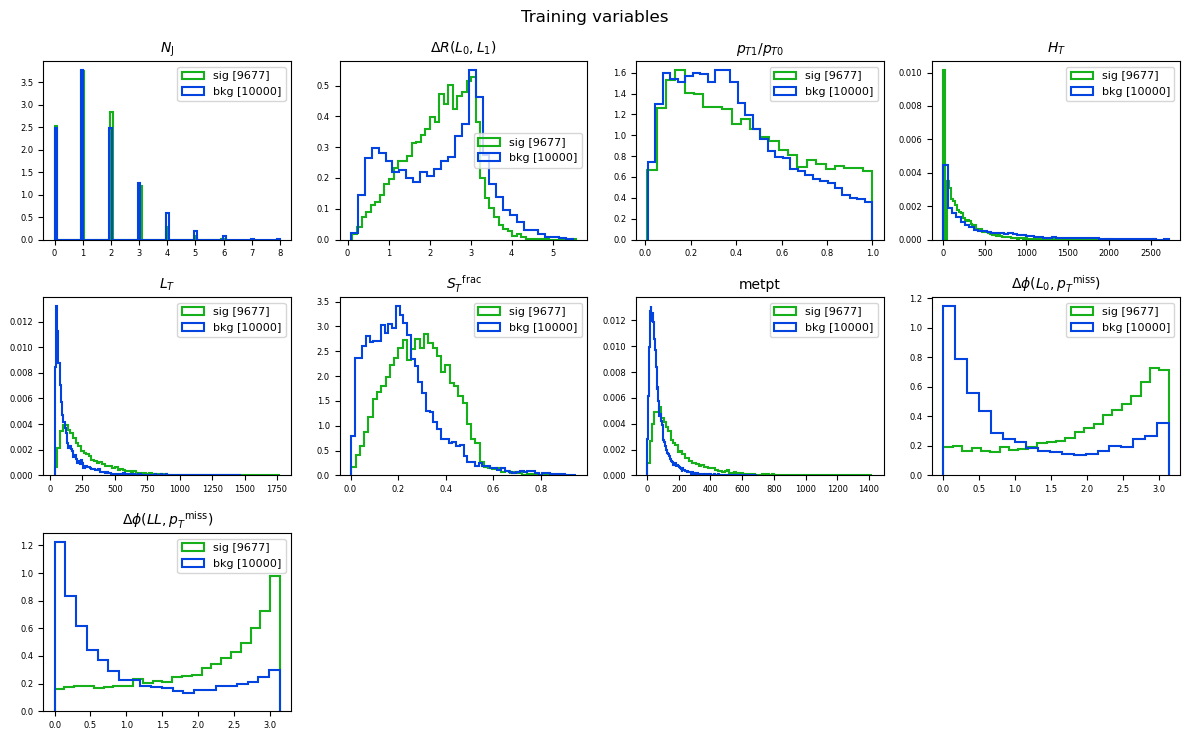

In [9]:
train_var = []

if modelname in ['qcd-vs-vlld-mu-2016preVFP_UL-feb06', 'qcd-vs-vlld-mu-2016postVFP_UL-feb06', 'qcd-vs-vlld-mu-2017_UL-feb06', 'qcd-vs-vlld-mu-2018_UL-feb06',
                 'qcd-vs-vlld-ele-2016preVFP_UL-feb06', 'qcd-vs-vlld-ele-2016postVFP_UL-feb06', 'qcd-vs-vlld-ele-2017_UL-feb06', 'qcd-vs-vlld-ele-2018_UL-feb06']:
    train_var = [
        'njet',
        'dilep_dR',
        'dilep_ptratio',
        'HT',
        'LT',
        'STfrac',
        'metpt',
        'dphi_metlep0',
        'dphi_metdilep'
    ]

alias_ = {
    'njet':            r'$N_{\text{J}}$',
    'lep0_eta':        r'$\eta (L_0)$',
    'lep1_eta':        r'$\eta (L_1)$',
    'dilep_mt':        r'$M_{T}^{\text{  LL}}$',
    'dilep_dR':        r'$\Delta R(L_{0}, L_{1})$',
    'dilep_dphi':      r'$\Delta\phi(L_{0}, L_{1})$',
    'dilep_deta':      r'$\Delta\eta(L_{0}, L_{1})$',
    'dilep_ptratio':   r'$p_{T1}/p_{T0}$',
    'HTMETllpt':       r'$H_{T}+p_{T}^{\text{  miss}}+ p_T^{\text{  LL}}$',
    'HT':              r'$H_{T}$',
    'LT':              r'$L_{T}$',
    'STfrac':          r'$S_{T}^{\text{  frac}}$',
    'dphi_metlep0':    r'$\Delta\phi(L_{0}, p_{T}^{\text{  miss}})$',
    'dphi_metlep1':    r'$\Delta\phi(L_{1}, p_{T}^{\text{  miss}})$',
    'dphi_metdilep':   r'$\Delta\phi(LL, p_{T}^{\text{  miss}})$',
    'dphi_metlep_max': r'$max\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$',
    'dphi_metlep_min': r'$min\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$'
} #Uses these names in plot. If not mentioned here, uses the dafault name.

print('The following input variables are chosen.')
for var in train_var: print(f"{var:<20}{latexname(var, alias_)}")

plot_in_group(train_var, 'training_varriables', suptitle='Training variables', alias=alias_)

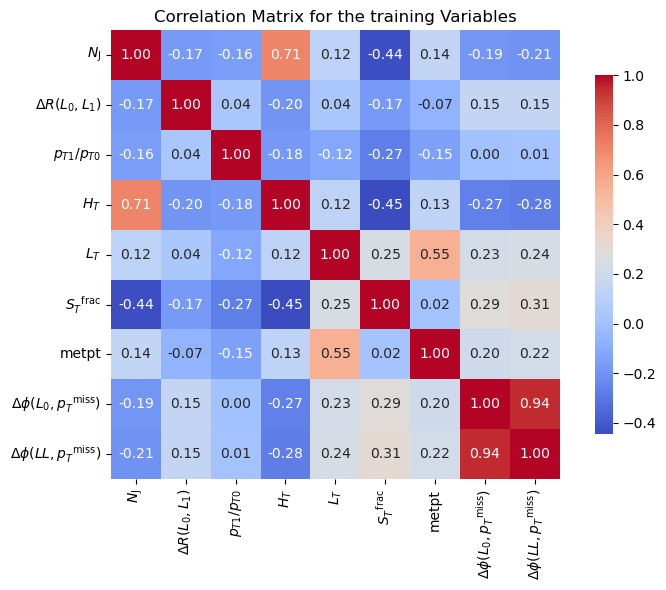

In [10]:
import seaborn as sns

correlation_data = df[train_var]
correlation_matrix = correlation_data.corr()

fig, ax = plt.subplots(figsize=(8, 6))

#sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, 
#            cbar_kws={"shrink": .8}, ax=ax, xticklabels=train_var, yticklabels=train_var)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8}, ax=ax, 
            xticklabels=[latexname(var, alias_) for var in train_var],  # Use LaTeX aliases for x-axis labels
            yticklabels=[latexname(var, alias_) for var in train_var])  # Use LaTeX aliases for y-axis labels

ax.set_title('Correlation Matrix for the training Variables', fontsize=12)

plt.tight_layout()
plt.savefig(f'{modelname}/before_training/correlation_trainvar.png', dpi=300, bbox_inches='tight')
plt.show()

## Preparing the Neural Network

In [11]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from tensorflow import keras
from keras import layers

2025-02-06 11:54:16.830253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training and testing dataset

In [12]:
df = df.sample(frac=1).reset_index(drop=True)
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['truth'])

#Randomizing again:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test  = df_test.sample(frac=1).reset_index(drop=True)

nsig_train = len(df_train.query('truth == 1'))
nsig_test  = len(df_test.query('truth == 1'))
nbkg_train = len(df_train.query('truth == 0'))
nbkg_test  = len(df_test.query('truth == 0'))

print(f'Statistics:')
print(f'nSig split into train and test: {nsig_train}, {nsig_test}')
print(f'nBkg split into train and test: {nbkg_train}, {nbkg_test}')

Statistics:
nSig split into train and test: 6773, 2904
nBkg split into train and test: 7000, 3000


### Min-max scaling

In [13]:
def FindMinMax(X, modelname):
    # Calculate min and max values
    maxval = X.max(axis=0)
    minval = X.min(axis=0)
    print('\n' + '-' * 25)
    print("Min Values found: ", minval)
    print("Max Values found: ", maxval)
    
    # Save min and max values to separate text files without headers
    np.savetxt(f'{modelname}/scaling_parameters_min.txt', minval, fmt='%.6f')
    np.savetxt(f'{modelname}/scaling_parameters_max.txt', maxval, fmt='%.6f')

def ApplyMinMax(X, min_filename, max_filename):
    # Load min values from the file
    minval = np.loadtxt(min_filename)
    
    # Load max values from the file
    maxval = np.loadtxt(max_filename)
    
    #print('Min from txt: ', minval)
    #print('Max from txt: ', maxval)
    
    # Calculate the difference
    diff = maxval - minval
    normed_X = X.copy()    
    # Scale the data only for non-constant columns
    nonconst = np.where(diff != 0)[0]
    normed_X[:, nonconst] = 2 * ((X[:, nonconst] - minval[nonconst]) / diff[nonconst]) - 1.0
    
    return normed_X

print('Functions for min-max scaling ready.')

Functions for min-max scaling ready.


In [14]:
#Numpy arrays that go into the training and testing:
X_train= df_train[train_var].values
y_train= df_train['truth'].values
X_test = df_test[train_var].values
y_test = df_test['truth'].values

FindMinMax(X_train, modelname)

X_train = ApplyMinMax(X_train, f'{modelname}/scaling_parameters_min.txt', f'{modelname}/scaling_parameters_max.txt')
X_test  = ApplyMinMax(X_test,  f'{modelname}/scaling_parameters_min.txt', f'{modelname}/scaling_parameters_max.txt')


-------------------------
Min Values found:  [0.00000000e+00 8.05698261e-02 8.06667004e-03 0.00000000e+00
 3.65795135e+01 1.46089948e-03 1.77719206e-01 2.44140625e-04
 5.82374632e-05]
Max Values found:  [8.00000000e+00 5.57211351e+00 9.99646723e-01 2.71571558e+03
 1.62464709e+03 9.22277153e-01 1.42218469e+03 3.14140058e+00
 3.14147472e+00]


In [15]:
column_index = 1  # Replace 'i' with the column index you're interested in
print(np.min(X_train[:, column_index]), np.max(X_train[:, column_index]))

-1.0000000633459392 0.9999998229811262


### Defining the model parameters

In [16]:
n_features = X_train.shape[1]
epochs_ = 30
batch_ = 100

model = keras.Sequential([
    layers.Input(shape=(n_features,)),  # Input layer
    layers.Dense(64, activation='relu'),  # Hidden layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(16, activation='relu'),  # Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#opt = tf.keras.optimizers.Adam(learning_rate=0.001)

### Training

In [17]:
%%time

history = model.fit(X_train,y_train,epochs=epochs_,batch_size=batch_,validation_data=(X_test,y_test),verbose=1)
model.save(f'{modelname}/model_{modelname}.keras')
print('Training complete!\n')


Epoch 1/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7009 - loss: 0.5855 - val_accuracy: 0.7949 - val_loss: 0.4361
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8175 - loss: 0.4158 - val_accuracy: 0.8692 - val_loss: 0.3417
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8530 - loss: 0.3551 - val_accuracy: 0.8667 - val_loss: 0.3166
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8670 - loss: 0.3276 - val_accuracy: 0.8784 - val_loss: 0.2959
Epoch 5/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8773 - loss: 0.3018 - val_accuracy: 0.8816 - val_loss: 0.2839
Epoch 6/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8740 - loss: 0.3031 - val_accuracy: 0.8838 - val_loss: 0.2805
Epoch 7/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8775 - loss: 0.2923 - val_accuracy: 0.8843 - val_loss: 0.2764
Epoch 8/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8754 - loss: 0.2910 - val_accuracy: 0.

In [18]:
from io import StringIO

info_filename = f'{modelname}/info_{modelname}.txt'

info = []
info.append(f'Model Name: {modelname}')
info.append(f'Signal and Background before filtering: {nsig}, {nbkg}')
info.append(f'Signal in training: {nsig_train}')
info.append(f'Signal in testing: {nsig_test}')
info.append(f'Background in training: {nbkg_train}')
info.append(f'Background in testing: {nbkg_test}')
info.append(f'Training Variables: {train_var}')
info.append(f'Number of Epochs: {epochs_}')
info.append(f'Batch Size: {batch_}')
info.append('\nModel Summary:\n')

model.summary()
buffer = StringIO()
model.summary(print_fn=lambda x: buffer.write(x + '\n'))
model_summary = buffer.getvalue()
info.append(model_summary)

# Write information to file
with open(info_filename, 'w') as f:
    for line in info:
        f.write(line + '\n')

print(f'Information saved to {info_filename}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,797 (38.27 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,532 (25.52 KB)

Information saved to qcd-vs-vlld-mu-2018_UL-feb06/info_qcd-vs-vlld-mu-2018_UL-feb06.txt


### Loss and accuracy

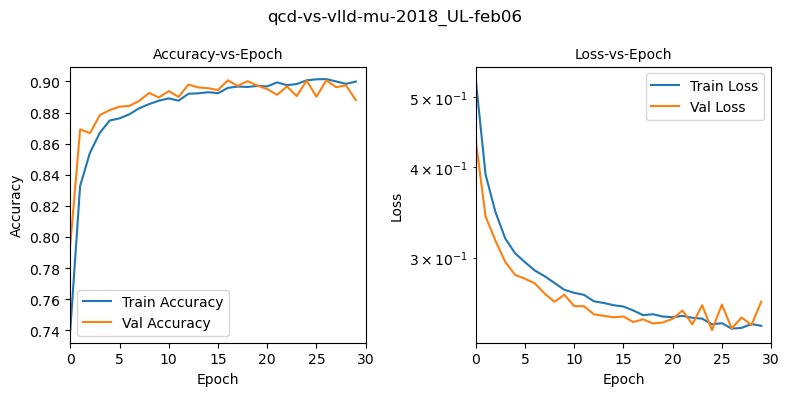

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Subplot 1: accuracy vs epoch
ax[0].plot(history.history['accuracy'],     label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Val Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_xlim(0, epochs_)
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy-vs-Epoch', fontsize=10)
ax[0].legend(loc='best')

# Subplot 2: loss vs epoch
ax[1].plot(history.history['loss'],     label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_xlim(0, epochs_)
ax[1].set_ylabel('Loss')
ax[1].set_yscale('log')
ax[1].legend(loc='best')
ax[1].set_title('Loss-vs-Epoch', fontsize=10)

fig.suptitle(modelname, fontsize=12)

plt.tight_layout()
plt.savefig(f'{modelname}/loss-and-accuracy.png')
plt.show()

### Using the trained model to predict

In [20]:
%%time

y_predicted_train = model.predict(X_train)
y_predicted_test  = model.predict(X_test)

df_train['score'] = y_predicted_train
df_test['score']  = y_predicted_test

# ROC information for the test dataset
fpr, tpr, _ = roc_curve(y_test, y_predicted_test)
auc_score = auc(tpr,1-fpr)
tpr=tpr*100
fnr=(1-fpr)*100

# ROC information for training data
fpr1, tpr1, _ = roc_curve(y_train, y_predicted_train)
auc_score1 = auc(tpr1,1-fpr1)
tpr1=tpr1*100
fnr1=(1-fpr1)*100

print('Done!\n')

431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
Done!

CPU times: user 812 ms, sys: 207 ms, total: 1.02 s
Wall time: 857 ms


### Performance check

In [21]:
display(df_test)

,channel,trigger,nlep,njet,nbjet,lep0_pt,lep0_eta,lep0_phi,lep0_iso,lep0_sip3d,...,jer,wt_leptonSF,wt_trig,wt_pileup,wt_bjet,weight,truth,sample,subsample,score
0,0,3,2,0,0,56.733982,0.591675,-1.797363,0.102724,10.757812,...,1.000000,0.981145,0.997546,1.028187,1.000000,1.006325,0,QCD_MuEnriched,120to170,0.341011
1,2,0,2,0,0,69.458458,2.324707,-1.706055,0.014999,6.648438,...,1.000000,0.970630,0.998764,1.058483,1.000000,1.026125,1,VLLD_mu,M200,0.112533
2,0,3,2,2,0,167.622467,0.330994,-1.892090,0.951425,1.884766,...,1.010409,0.991395,0.950463,1.006624,1.046049,0.948526,0,QCD_MuEnriched,800to1000,0.002282
3,2,1,2,2,0,250.147919,1.205811,-2.013672,0.023246,1.428711,...,0.983749,1.021468,0.962897,0.990842,1.000000,0.974561,0,QCD_MuEnriched,600to800,0.174455
4,1,0,2,4,0,42.040104,1.489502,0.958862,0.135862,0.969727,...,0.973080,0.993483,0.953162,0.856406,0.766293,0.810974,0,QCD_MuEnriched,600to800,0.013720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5899,0,0,2,1,0,169.472992,-0.163696,-2.635254,0.000978,0.309082,...,0.998312,0.968681,0.950463,0.992863,1.008478,0.914125,1,VLLD_mu,M400,0.454092
5900,0,0,2,1,1,198.251282,-0.157501,0.053200,0.003965,0.848145,...,1.013231,0.982864,0.997546,0.987395,0.954257,0.968094,1,VLLD_mu,M600,0.973168
5901,0,3,2,0,0,50.280624,2.026367,2.185059,0.477833,5.699219,...,1.000000,0.980387,0.997806,1.095100,1.000000,1.071266,0,QCD_MuEnriched,80to120,0.228340
5902,0,3,2,0,0,35.211899,1.983398,2.320801,0.482633,0.861328,...,1.000000,0.990289,0.953162,0.990842,1.000000,0.935262,0,QCD_MuEnriched,80to120,0.098414


In [22]:
%%capture

mybins = np.arange(0, 1.02, 0.02)
density_ = False

def extract_plot(df_, truth_, mybins, density_):
    scores_ = df_[df_['truth'] == truth_]['score']
    hist_ = plt.hist(scores_, bins=mybins, density=density_)
    counts_, bins_, _ = hist_
    errors_ = np.sqrt(counts_)
    integral_ = np.sum(counts_)
    scale_ = integral_ / len(scores_) if len(scores_) > 0 else 1
    weights_ = np.ones_like(scores_)
    if density_ == True: weights_ = np.ones_like(scores_) * (scale_ / len(scores_)) #Normalise integral to 1    
    return scores_, bins_, weights_, counts_, errors_

train_scores_sig, bins_sig_train, weights_sig_train, counts_sig_train, errors_sig_train = extract_plot(df_train, 1, mybins, density_)
train_scores_bkg, bins_bkg_train, weights_bkg_train, counts_bkg_train, errors_bkg_train = extract_plot(df_train, 0, mybins, density_)
test_scores_sig, bins_sig_test, weights_sig_test, counts_sig_test, errors_sig_test =      extract_plot(df_test,  1, mybins, density_)
test_scores_bkg, bins_bkg_test, weights_bkg_test, counts_bkg_test, errors_bkg_test =      extract_plot(df_test,  0, mybins, density_)

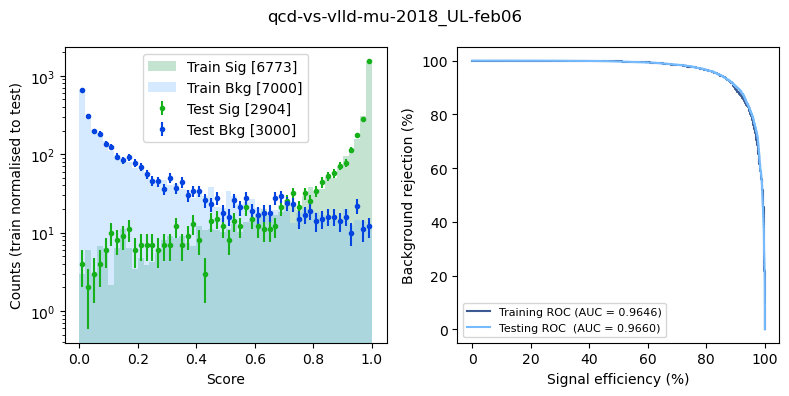

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

decorate_hist = {
    'bins':mybins,
    'histtype':'step',
    'linewidth':1.5,
    'density': density_,
    'log': False,
    'alpha':1.0
}

decorate_point ={
    'marker':'o',
    'markersize':3,
    'linestyle':''
}

if density_:
    ax[0].hist(train_scores_sig, color='xkcd:greenish', label=f'Train Sig [{len(train_scores_sig)}]', alpha=0.3, bins=mybins, density=density_)
    ax[0].hist(train_scores_bkg, color='xkcd:sky blue', label=f'Train Bkg [{len(train_scores_bkg)}]', alpha=0.3, bins=mybins, density=density_)
    ax[0].hist(test_scores_sig,  color='xkcd:green', label=f'Test Sig [{len(test_scores_sig)}]', **decorate_hist)
    ax[0].hist(test_scores_bkg,  color='xkcd:blue',  label=f'Test Bkg [{len(test_scores_bkg)}]',**decorate_hist)

else:
    # Calculate the scaling factors to normalize train histograms to match test integrals
    scale_factor_sig = np.sum(counts_sig_test) / np.sum(counts_sig_train) if np.sum(counts_sig_train) > 0 else 1
    scale_factor_bkg = np.sum(counts_bkg_test) / np.sum(counts_bkg_train) if np.sum(counts_bkg_train) > 0 else 1

    # Make train plots, normalized to match test histogram integrals
    ax[0].hist(train_scores_sig, color='xkcd:greenish', label=f'Train Sig [{len(train_scores_sig)}]', 
               alpha=0.3, bins=mybins, density=False, weights=np.ones_like(train_scores_sig) * scale_factor_sig)
    ax[0].hist(train_scores_bkg, color='xkcd:sky blue', label=f'Train Bkg [{len(train_scores_bkg)}]', 
               alpha=0.3, bins=mybins, density=False, weights=np.ones_like(train_scores_bkg) * scale_factor_bkg)
    
    # Make test plots with error bars
    ax[0].errorbar(bins_sig_test[:-1] + np.diff(bins_sig_test) / 2, 
                   counts_sig_test, 
                   yerr=errors_sig_test, 
                   color='xkcd:green', label=f'Test Sig [{len(test_scores_sig)}]', 
                   fmt='o', markersize=3)
    
    ax[0].errorbar(bins_bkg_test[:-1] + np.diff(bins_bkg_test) / 2, 
                   counts_bkg_test, 
                   yerr=errors_bkg_test, 
                   color='xkcd:blue', label=f'Test Bkg [{len(test_scores_bkg)}]', 
                   fmt='o', markersize=3)

ax[0].set_xlabel('Score')
if density_:     ax[0].set_ylabel('Counts (normalized)')
if not density_: ax[0].set_ylabel('Counts (train normalised to test)')
ax[0].set_yscale('log')
ax[0].legend(loc='best')

ax[1].plot(tpr, fnr, color='xkcd:denim blue', label='Training ROC (AUC = %0.4f)' % auc_score)
ax[1].plot(tpr1,fnr1,color='xkcd:sky blue',   label='Testing ROC  (AUC = %0.4f)'  % auc_score1)
ax[1].set_xlabel('Signal efficiency (%)')
ax[1].set_ylabel('Background rejection (%)')
ax[1].legend(loc='best', fontsize=8)

fig.suptitle(modelname, fontsize=12)

plt.tight_layout()
plt.savefig(f'{modelname}/performance.png')
plt.show()

### Permutation importance of the training variables

In [24]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import warnings
import io
from contextlib import redirect_stdout, redirect_stderr

# Suppress warnings
warnings.filterwarnings("ignore")

# Define a scoring function compatible with permutation_importance
def keras_accuracy(model, X, y):
    # Get predictions
    y_pred = model.predict(X)
    # For binary classification, threshold predictions at 0.5
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()
    return accuracy_score(y, y_pred_classes)

# Capture stdout and stderr to suppress output
f = io.StringIO()
with redirect_stdout(f), redirect_stderr(f): 
    # Calculate permutation importance
    result = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=30,
        random_state=42,
        n_jobs=-1,
        scoring=keras_accuracy
    )

# Optional: Print or return the result if needed
# print(result)

2025-02-06 11:54:33.246439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-06 11:54:33.286764: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-06 11:54:33.288454: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-06

185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
185/185 ━━━━━

Sorted Features and Importance Scores:
HT                   0.175
metpt                0.146
dphi_metdilep        0.127
LT                   0.093
njet                 0.085
dphi_metlep0         0.048
STfrac               0.025
dilep_dR             0.023
dilep_ptratio        0.021


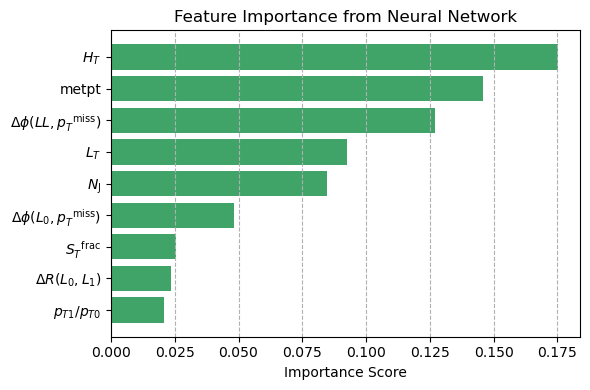

In [25]:
# Get feature importance scores and corresponding variable names
importance_scores = result.importances_mean
feature_names = train_var

# Sort importance scores and corresponding feature names
sorted_indices = np.argsort(importance_scores)[::-1]  # Indices for sorting from most to least
sorted_importance_scores = importance_scores[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]
# Apply LaTeX aliases to the sorted feature names
sorted_feature_names_latex = [latexname(name, alias_) for name in sorted_feature_names]

# Print the sorted features and importance scores
print("Sorted Features and Importance Scores:")
for name, score in zip(sorted_feature_names, sorted_importance_scores):
    print(f"{name:<20} {score:.3f}")

# Prepare the plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(sorted_feature_names_latex, sorted_importance_scores, color='xkcd:greenish')  # Use LaTeX aliases
ax.invert_yaxis()
ax.set_xlabel('Importance Score')
#ax.set_ylabel('Features')
ax.set_title('Feature Importance from Neural Network')
ax.grid(axis='x', linestyle='--')

# Save and show the plot
plt.tight_layout()
plt.savefig(f'{modelname}/feature_importance.png', bbox_inches='tight')  # Save with tight bounding box
plt.show()
